# GEONE - DEESSEX - Getting started

The principle of deesseX is to fill the simulation grid by successively simulating sections with deesse (according the the given orientation) conditionally to the sections previously simulated. The name deesseX refers to crossing-simulation / X-simulation with deesse.

## Reference
A. Comunian, P. Renard, J. Straubhaar (2012) 3D multiple-point statistics simulation using 2D training images. Computers & Geosciences 40, 49-65, [doi:10.1016/j.cageo.2011.07.009](https://dx.doi.org/10.1016/j.cageo.2011.07.009)

## Example - 3D simulation from 2D sections parallel to XZ and YZ planes

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import time
import os

# import package 'geone'
import geone as gn

In [2]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Training images
Read the TIs for sections parallel to XZ plane and the TI for sections parallel to YZ plane.

The TIs represent vertical sections for modeling the Brussels Sands sedimentary environment, with clay-rich bottom set (facies 0) and mud drapes (facies 1). See reference: A. Comunian, P. Renard, J. Straubhaar (2012) 3D multiple-point statistics simulation using 2D training images. Computers & Geosciences 40, 49-65, [doi:10.1016/j.cageo.2011.07.009](https://dx.doi.org/10.1016/j.cageo.2011.07.009).

Source of the images: *Huysmans, M., Peeters, L., Moermans, G., Dassargues, A., 2008. Relating small-scale sedimentary structures and permeability in a cross-bedded aquifer. Journal of Hydrology 361 (1–2), 41–51. [doi:10.1016/j.jhydrol.2008.07.047](https://doi.org/10.1016/j.jhydrol.2008.07.047).*

In [3]:
data_dir = 'data'
ti_xz = gn.img.readImageTxt(os.path.join(data_dir, 'houthuys1.txt'))
ti_yz = gn.img.readImageTxt(os.path.join(data_dir, 'houthuys2.txt'))

print(f'TI xz dimension: {ti_xz.nx} x {ti_xz.ny} x {ti_xz.nz}')
print(f'TI yz dimension: {ti_yz.nx} x {ti_yz.ny} x {ti_yz.nz}')

TI xz dimension: 600 x 600 x 1
TI yz dimension: 600 x 600 x 1


The TIs read are in the 2D images in the plane XY.

In [4]:
categVal = [0, 1] # facies
categCol = ['lightblue', 'orange']

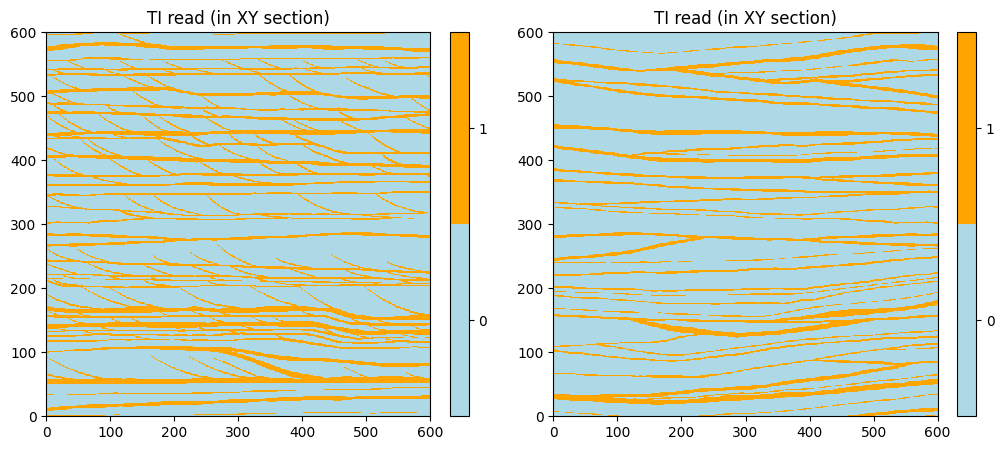

In [5]:
# Plot TI read
plt.subplots(1,2, figsize=(12,8))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti_xz, categ=True, categVal=categVal, categCol=categCol)
plt.title('TI read (in XY section)')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti_yz, categ=True, categVal=categVal, categCol=categCol)
plt.title('TI read (in XY section)')

plt.show()

### Re-orient the TIs (if needed)
The TIs must be re-oriented with respect to the sections for which they will be used during the simulation.

In [6]:
# TI for XZ section:
ti_xz.swap_yz() # permutes axes y and z

# TI for YZ section:
ti_yz.transpose_xyz_to_yzx() # transpose by sending axes x,y,z onto y,z,x

print(f'TI xz dimension: {ti_xz.nx} x {ti_xz.ny} x {ti_xz.nz}')
print(f'TI yz dimension: {ti_yz.nx} x {ti_yz.ny} x {ti_yz.nz}')

TI xz dimension: 600 x 1 x 600
TI yz dimension: 1 x 600 x 600


Plot the TIs to be sure of their orientation in the desired plane. Check also the cell size.

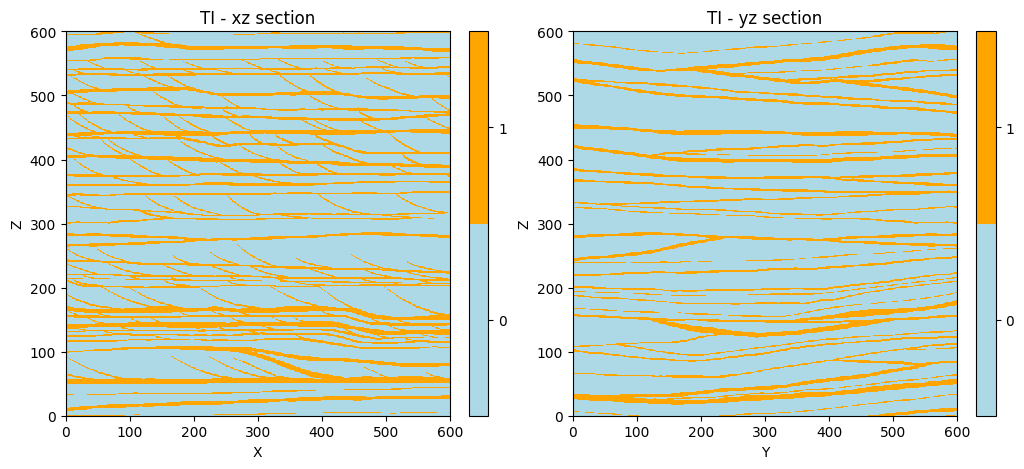

TI xz cell size: 1.0 x 1.0 x 1.0
TI yz cell size: 1.0 x 1.0 x 1.0


In [7]:
# Figure
plt.subplots(1,2, figsize=(12,8))

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(ti_xz, iy=0, xlabel='X', ylabel='Z', categ=True, categVal=categVal, categCol=categCol)
plt.title('TI - xz section')

plt.subplot(1,2,2)
gn.imgplot.drawImage2D(ti_yz, ix=0, xlabel='Y', ylabel='Z', categ=True, categVal=categVal, categCol=categCol)
plt.title('TI - yz section')

plt.show()

print(f'TI xz cell size: {ti_xz.sx} x {ti_xz.sy} x {ti_xz.sz}')
print(f'TI yz cell size: {ti_yz.sx} x {ti_yz.sy} x {ti_yz.sz}')

## Defining simulation grid and variable(s)
These parameters will be used in the set up for deesseX further.

In [8]:
# Simulation grid (3D)
nx, ny, nz = 80, 90, 78
sx, sy, sz = 1.0, 1.0, 1.0
ox, oy, oz = 0.0, 0.0, 0.0

# Variable(s)
nv = 1
varname = 'facies'
distanceType='categorical'

## Set up for deesseX

The input parameters required to run deesseX are specified with the following classes:

- `gn.deesseinterface.DeesseXInput`: general input
- `gn.deesseinterface.DeesseXInputSectionPath`: input defining the strategy of simulation, i.e. which type of sections (orientation) will be simulated and the section path (succession of sections)
- `gn.deesseinterface.DeesseXInputSection`: input defining the deesse parameters for one section type

### Input for strategy of simulation (class `gn.deesseinterface.DeesseXInputSectionPath`)

The parameter `sectionMode` (string) defines which types of section will be simulated alternately

- 'section_\<t1\>_\<t2\>' or 'section_\<t1\>_\<t2\>_\<t3\>' with '\<ti\>' in 'xy', 'xz', 'yz' (2D sections), 'z', 'y', 'x' (1D sections)

The parameter `sectionPathMode` (string) defines the way to determine the section path, i.e. the succession of simulated sections:
- 'section_path_random', 'section_path_pow_2', 'section_path_subdiv', 'section_path_manual'

The section path may also depends on other parameters depending on the section path mode specified (see help of the class for more details).

In [9]:
# Strategy of simulation
deesseX_input_section_path = gn.deesseinterface.DeesseXInputSectionPath(
    sectionMode='section_xz_yz',
    sectionPathMode='section_path_subdiv'
)

### Input for deesse parameters for each section type  (class `gn.deesseinterface.DeesseXInputSection`)
For each section type involved in the simulation (according to section mode above), the deesse parameters for the section of that type has to be specified by an instance of the class `gn.deesseinterface.DeesseXInputSection`. 

See examples on deesse for more details; note that not all options of deesse are available.

In [10]:
# Deesse parameters for ...
# ... section parallel to xz plane
deesseX_input_section_xz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='xz',           # section type for which the deesse parameters are defined
    TI=ti_xz,                   # TI (class gn.deesseinterface.Img)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

# ... section parallel to yz plane
deesseX_input_section_yz = gn.deesseinterface.DeesseXInputSection(
    nx=nx, ny=ny, nz=nz, nv=nv, # dimension of the simulation grid (number of cells), number of variable(s)
    distanceType=distanceType,  # distance type
    sectionType='yz',           # section type for which the deesse parameters are defined
    TI=ti_yz,                   # TI (class gn.deesseinterface.Img)
    nneighboringNode=24,        # max. number of neighbors (for the patterns)
    distanceThreshold=0.02,     # acceptation threshold (for distance between patterns)
    maxScanFraction=0.25,       # max. scanned fraction of the TI (for simulation of each cell)
    npostProcessingPathMax=1,   # number of post-processing path(s)
)

### General Input for deesseX  (class `gn.deesseinterface.DeesseXInput`)
Finally, all the parameters are gathered in a general input for deesseX.

In [11]:
# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,        # dimension of the simulation grid (number of cells)
    sx=sx, sy=sy, sz=sz,        # cells units in the simulation grid (here are the default values)
    ox=ox, oy=oy, oz=oz,        # origin of the simulation grid (here are the default values)
    nv=nv, varname=varname,     # number of variable(s), name of the variable(s)
    distanceType=distanceType,  # distance type: proportion of mismatching nodes (categorical var., default)
    sectionPath_parameters=deesseX_input_section_path, 
                                # section path (defining the succession of section to be simulated)
                                # (class gn.deesseinterface.DeesseXInputSectionPath)
    section_parameters=[deesseX_input_section_xz, deesseX_input_section_yz],
                                # simulation parameters for each section type
                                # (sequence of class gn.deesseinterface.DeesseXInputSection)
    seed=444,                   # seed (initialization of the random number generator)
    nrealization=1)             # number of realization(s)

## Launching deesseX

The function `geone.deesseinterface.deesseXRun` launches deesseX; the number of threads used (parallel code based on *OpenMP*) can be specified with the keyword argument `nthreads`.

The function `geone.deesseinterface.deesseXRun_mp` launches deesseX on multiple processes.

The principles are the same ones as for launching deesse (functions `geone.deesseinterface.deesseRun[_mp]`, see jupyter notebook `ex_deesse_01_basics.ipynb`).

In [12]:
# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseXRun: DeeSseX running... [VERSION 1.0 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseXRun: DeeSseX run complete
Elapsed time: 43 sec


## Retrieve the results (and display)
The function `geone.deesseinterface.deesseXRun[_mp]` returns a dictionary `deesseX_output` containing the keys: `'sim'`, `'nwarnings'`, `'warnings'` (plus other ones).

The realizations are stored in `deesseX_output['sim']`, a 1-dimensional array of *images* (class `geone.img.Img`) of size `deesseX_input.nrealization`, `deesseX_output['sim'][i]` being the i-th realization.

The total number of warning(s) encountered during the simulation are stored in `deesseX_output['nwarning']` (*int*), and all the distinct warning messages are stored in `deesseX_output['warnings']` (a list, possibly empty).

Moreover, additional information can be retrieved in output: the section type map and the section step map (see further).

In [13]:
deesseX_output

{'sim': array([*** Img object ***
        name = ''
        (nx, ny, nz) = (80, 90, 78) # number of cells along each axis
        (sx, sy, sz) = (1.0, 1.0, 1.0) # cell size (spacing) along each axis
        (ox, oy, oz) = (0.0, 0.0, 0.0) # origin (coordinates of bottom-lower-left corner)
        nv = 1  # number of variable(s)
        varname = [np.str_('facies_real00000')]
        val: (1, 78, 90, 80)-array
        *****                                                                            ],
       dtype=object),
 'sim_var_original_index': array([0], dtype=int32),
 'simSectionType': None,
 'simSectionStep': None,
 'nwarning': 0,
 'warnings': []}

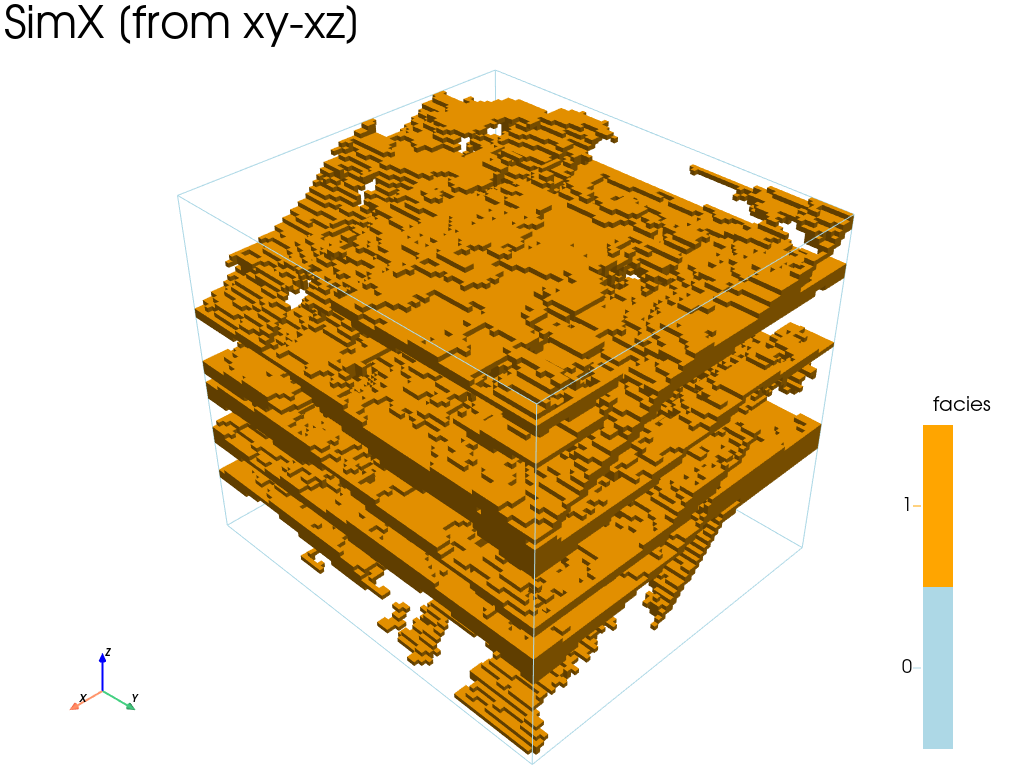

In [14]:
# Retrieve the results
sim = deesseX_output['sim'][0]

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_surface(
    sim, 
    plotter=pp,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    categActive=[False, True], # display only category value (in categVal) with True
    alpha=1, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text=f'SimX [from xy-xz]')

pp.show()

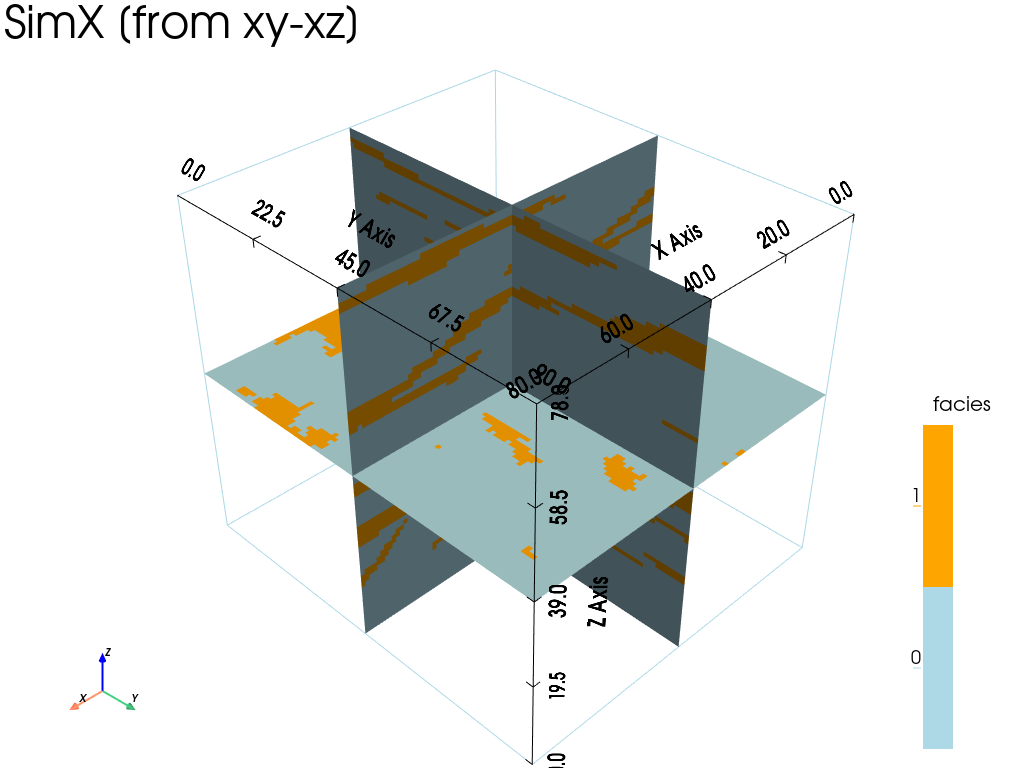

In [15]:
# Plot some slices
# Slices orthogonal to the axes, going through the center of the images
cx = sim.ox + 0.5 * sim.nx * sim.sx # center along x
cy = sim.oy + 0.5 * sim.ny * sim.sy # center along y
cz = sim.oz + 0.5 * sim.nz * sim.sz # center along z

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(notebook=False)
# ... inline
pp = pv.Plotter()

gn.imgplot3d.drawImage3D_slice(
    sim,
    plotter=pp,
    slice_normal_x=cx, 
    slice_normal_y=cy, 
    slice_normal_z=cz,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    # categActive=[True, True, True], # by default, every category value in categVal is displayed
    show_bounds=True,   # add bounds (axis with graduation)
    scalar_bar_kwargs={'title':'facies', 'title_font_size':20, 'vertical':True},
    text=f'SimX [from xy-xz]')

pp.show()

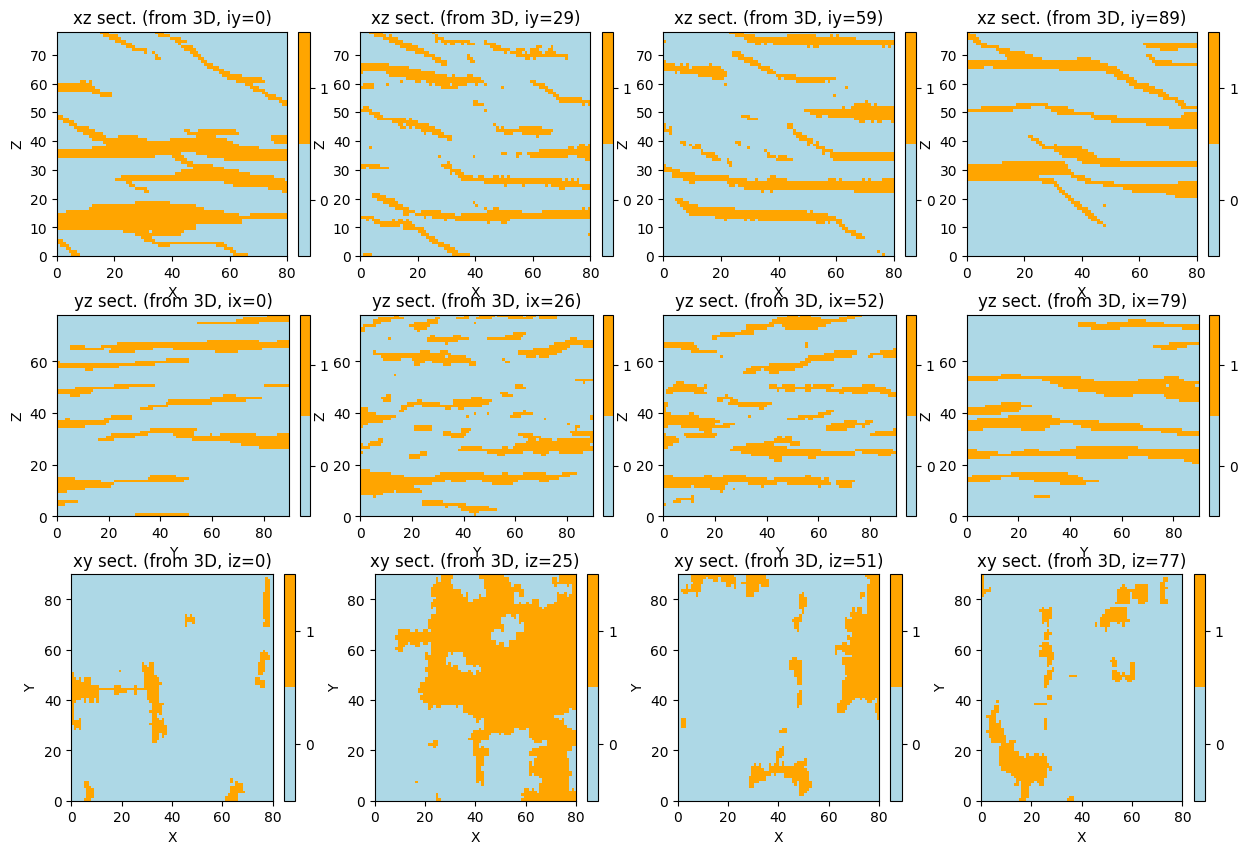

In [16]:
# Plot some slices in 2D
ix = np.asarray(np.linspace(0, sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis
iy = np.asarray(np.linspace(0, sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis
iz = np.asarray(np.linspace(0, sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

plt.subplots(3,4, figsize=(15,10))

k = 1
for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iy=i, categ=True, categVal=categVal, categCol=categCol, 
                           xlabel='X', ylabel='Z')
    plt.title(f'xz sect. (from 3D, iy={i})')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, ix=i, categ=True, categVal=categVal, categCol=categCol,
                           xlabel='Y', ylabel='Z')
    plt.title(f'yz sect. (from 3D, ix={i})')
    k = k+1

for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iz=i, categ=True, categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Y')
    plt.title(f'xy sect. (from 3D, iz={i})')
    k = k+1

plt.show()

## Getting additional output from deesseX

Additional information consisting of output maps (whose support is the simulation grid) can be retrieved in output when running deesseX.

### Section type map
It consists of an id attached to each simulation grid cell. The id identifies which type of section was used for simulating the cell. The id's are defined as follows.

| Section type (id) | section orientation |
|-----------------: | :------------------ |
|                 0 | xy (2D)             |
|                 1 | xz (2D)             |
|                 2 | yz (2D)             |
|                 3 |  z (1D)             |
|                 4 |  y (1D)             |
|                 5 |  x (1D)             |

### Section step map
It consists of an index attached to each simulation grid cell. Each section step index gives the order of simulation by deesse of (bunch of) sections of same type.

### Remarks
Depending on section path mode that was used, one section type / section step map **per** realization is retrieved (deesseX_input.sectionPath_parameters.sectionPathMode='section_path_random'), or one one section type / section step map valid for **all** realizations is retrieved. 

### Filling the input structure for deesseX
To get such maps in output, in the general input for deesseX  (class `gn.deesseinterface.DeesseXInput`), set corresponding flags (keyword arguments) to `True`:

- section type map: flag `outputSectionTypeFlag`
- section step map: flag `outputSectionStepFlag`

Note that, by default, these flags are set to `False`.

### Retrieving additional output (after running deesseX)
The additional output maps are retrieved in ouput in the dictionary `deesseX_output` with the associated key `'simSectionType'` and `'simSectionStep'`.

In [17]:
# Main input for deesseX
deesseX_input = gn.deesseinterface.DeesseXInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=nv, varname=varname,
    distanceType=distanceType,
    sectionPath_parameters=deesseX_input_section_path, 
    section_parameters=[deesseX_input_section_xz, deesseX_input_section_yz],
    outputSectionTypeFlag=True, # retrieve section type map in output
    outputSectionStepFlag=True, # retrieve section step map in output
    seed=555,                   # (other seed)
    nrealization=1)

# Run deesseX
t1 = time.time() # start time
deesseX_output = gn.deesseinterface.deesseXRun(deesseX_input)
t2 = time.time() # end time
print(f'Elapsed time: {t2-t1:.2g} sec')

deesseXRun: DeeSseX running... [VERSION 1.0 / BUILD NUMBER 20230914 / OpenMP 19 thread(s)]
deesseXRun: DeeSseX run complete
Elapsed time: 43 sec


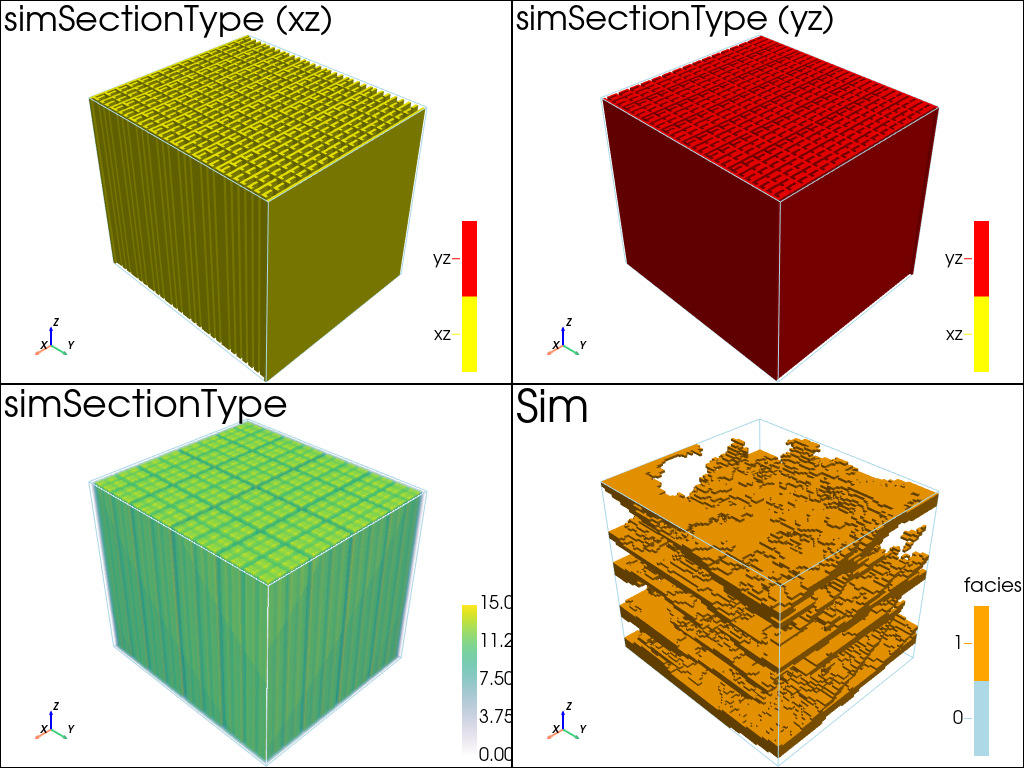

In [18]:
# Retrieve the results
sim = deesseX_output['sim'][0]
simSectionType = deesseX_output['simSectionType'][0]
simSectionStep = deesseX_output['simSectionStep'][0]

categValSectType = [1, 2] # value of the section type id (1: xz, 2: yz)
categColSectType = ['yellow', 'red'] # color for section type

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

for i, (active, type_str) in enumerate(zip([[True, False], [False, True]], ['xz', 'yz'])):
    pp.subplot(0,i)
    gn.imgplot3d.drawImage3D_surface(simSectionType, plotter=pp,
        categ=True,
        categVal=categValSectType,
        categCol=categColSectType,
        categActive=active, # display only category value (in categVal) with True
        alpha=1, # transparency (alpha channel)
        scalar_bar_annotations={0.5:'xz', 1.5:'yz'}, # (add 0.5 to center the label)
        scalar_bar_kwargs={'title':(i+1)*' ', 'vertical':True}, # distinct title in each subplot 
                                                                #    for correct display!
        text=f'simSectionType ({type_str})')

pp.subplot(1,0)
gn.imgplot3d.drawImage3D_volume(simSectionStep, plotter=pp,
    scalar_bar_kwargs={'title':'    ', 'vertical':True}, # distinct title in each subplot for correct display!
    text='simSectionType')

pp.subplot(1,1)
gn.imgplot3d.drawImage3D_surface(sim, plotter=pp,
    categ=True,
    categVal=categVal,
    categCol=categCol,
    categActive=[False, True], # display only category value (in categVal) with True
    alpha=1, # transparency (alpha channel)
    scalar_bar_kwargs={'title':'facies','title_font_size':20, 'vertical':True},
    text='Sim')

pp.link_views()
pp.show()

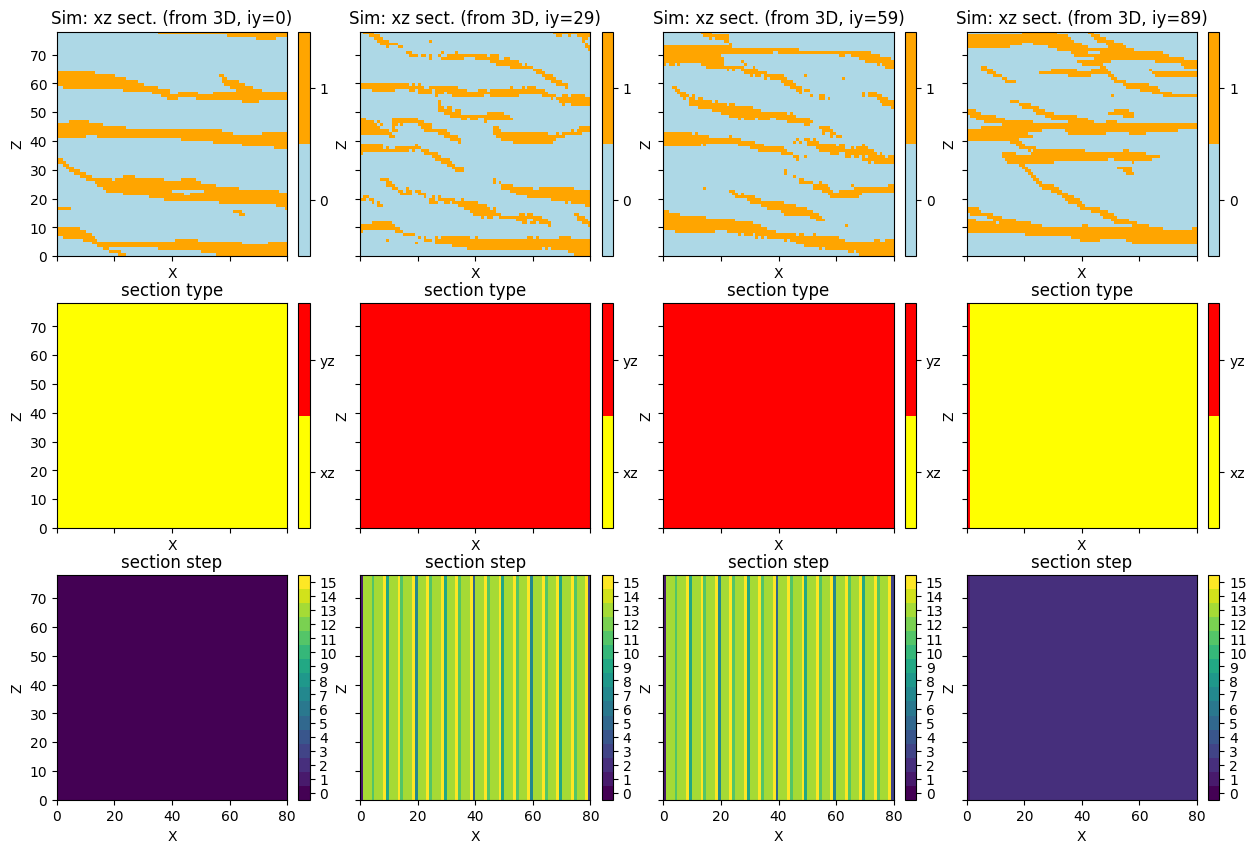

In [19]:
# Plot some slices in 2D - xz section
iy = np.asarray(np.linspace(0, sim.ny-1, 4), dtype='int') # indexes of section orthogonal to y-axis

plt.subplots(3,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iy=i, categ=True, 
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Z')
    plt.title(f'Sim: xz sect. (from 3D, iy={i})')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, iy=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xz', 'yz'],
                           xlabel='X', ylabel='Z')
    plt.title('section type')
    k = k+1

for i in iy:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, iy=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='X', ylabel='Z')
    plt.title('section step')
    k = k+1

plt.show()

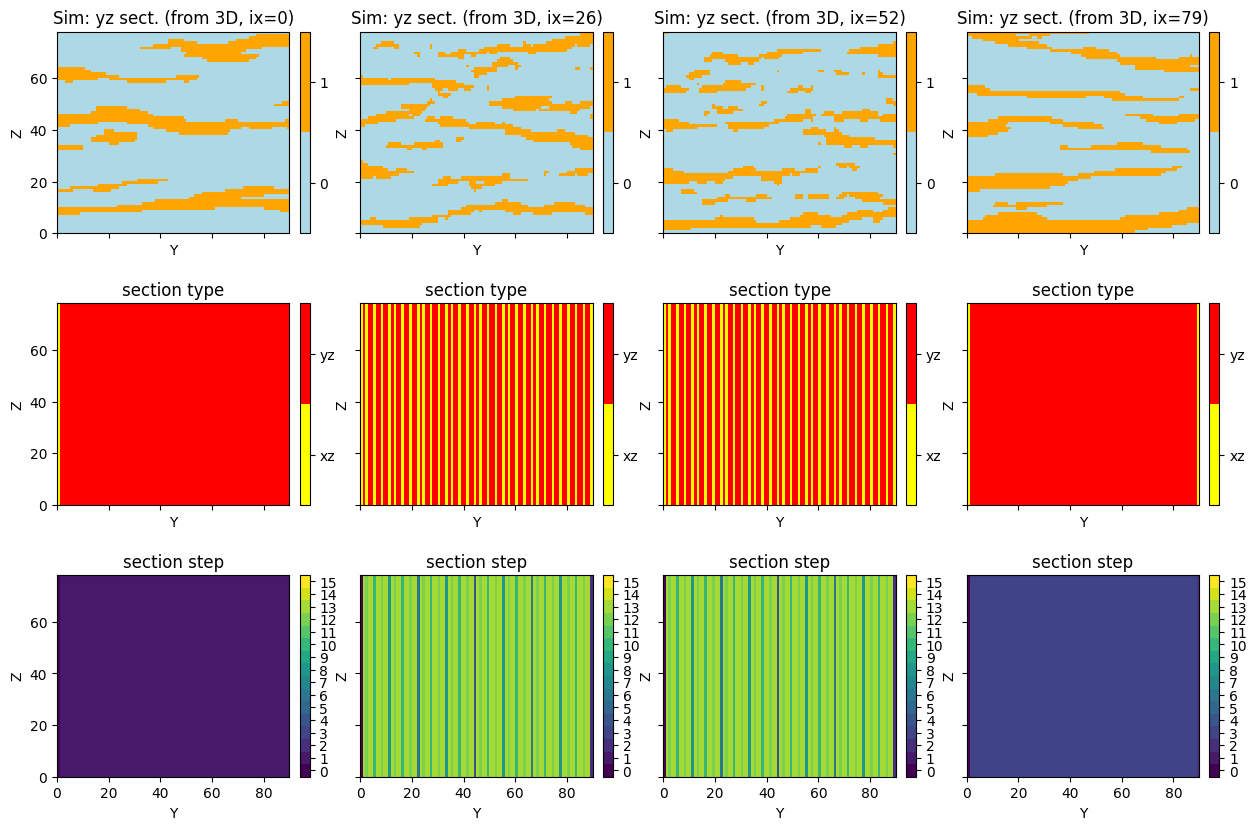

In [20]:
# Plot some slices in 2D - yz section
ix = np.asarray(np.linspace(0, sim.nx-1, 4), dtype='int') # indexes of section orthogonal to x-axis

plt.subplots(3,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, ix=i, categ=True, 
                           categVal=categVal, categCol=categCol,
                           xlabel='Y', ylabel='Z')
    plt.title(f'Sim: yz sect. (from 3D, ix={i})')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, ix=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xz', 'yz'],
                           xlabel='Y', ylabel='Z')
    plt.title('section type')
    k = k+1

for i in ix:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, ix=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='Y', ylabel='Z')
    plt.title('section step')
    k = k+1

plt.show()

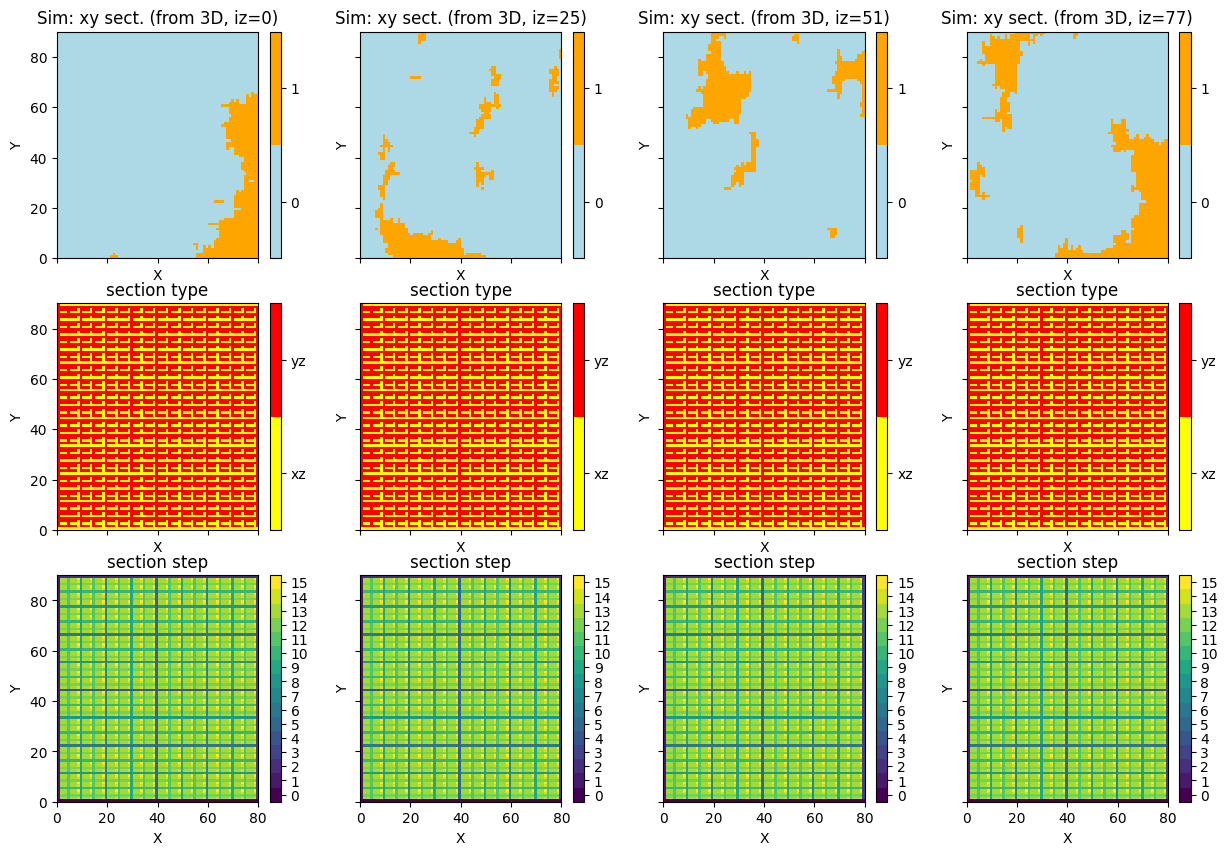

In [21]:
# Plot some slices in 2D - xy section
iz = np.asarray(np.linspace(0, sim.nz-1, 4), dtype='int') # indexes of section orthogonal to z-axis

plt.subplots(3,4, figsize=(15,10), sharex=True, sharey=True)

k = 1
for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(sim, iz=i, categ=True, 
                           categVal=categVal, categCol=categCol,
                           xlabel='X', ylabel='Y')
    plt.title(f'Sim: xy sect. (from 3D, iz={i})')
    k = k+1

for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionType, iz=i, categ=True, 
                           categVal=categValSectType, categCol=categColSectType,
                           cticklabels=['xz', 'yz'],
                           xlabel='X', ylabel='Y')
    plt.title('section type')
    k = k+1

for i in iz:
    plt.subplot(3,4,k)
    gn.imgplot.drawImage2D(simSectionStep, iz=i, categ=True,
                           categVal=np.arange(0, np.max(simSectionStep.val) + 1),
                           xlabel='X', ylabel='Y')
    plt.title('section step')
    k = k+1

plt.show()